<a href="https://colab.research.google.com/github/ramprakashyadav/OCR/blob/main/Objectdetection2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%tensorflow_version 1.x

In [7]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
%cd '/content/gdrive/My Drive/tensorflow/'

/content/gdrive/My Drive/tensorflow


In [10]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.4).
python-pil is already the newest version (5.1.0-1ubuntu0.6).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [11]:
%cd /content/gdrive/My Drive/tensorflow/models/research/
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/My Drive/tensorflow/models/research


In [12]:
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/tensorflow/models/research/:/content/gdrive/My Drive/tensorflow/models/research/slim'

In [13]:
!python setup.py build
!python setup.py install

running build
running build_py
copying object_detection/train.py -> build/lib/object_detection
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/center_net_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/flexible_grid_anchor_generator_pb2.py -> build/lib/object_detecti

In [14]:
%cd /content/gdrive/My Drive/tensorflow/models/research/object_detection/builders/
!python model_builder_test.py

/content/gdrive/My Drive/tensorflow/models/research/object_detection/builders


In [15]:
%cd /content/gdrive/My Drive/tensorflow/models/research/object_detection

/content/gdrive/My Drive/tensorflow/models/research/object_detection


In [16]:
%load_ext tensorboard
%tensorboard --logdir training/

In [17]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

Instructions for updating:
Use object_detection/model_main.py.
W0107 08:47:02.821680 139963958843264 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W0107 08:47:03.829524 139963958843264 deprecation.py:323] From /content/gdrive/My Drive/tensorflow/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Reading unweighted datasets: ['train.record']
I0107 08:47:04.363733 139963958843264 dataset_builder.py:163] Reading unweighted datasets: ['train.record']
INFO:tensorflow:Reading record datasets for input file: ['train.record']
I0107 08:47:04.366150 139963958843

In [18]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_inception_v2_pets.config --trained_checkpoint_prefix training/model.ckpt-0 --output_directory inference_graph

Instructions for updating:
Please use `layer.__call__` method instead.
W0107 12:37:36.884883 140098366244736 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim-1.1.0-py3.7.egg/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0107 12:37:38.119915 140098366244736 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0107 12:37:38.240892 140098366244736 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0107 12:37:38.241338 140098366244736 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0107 12:37:38.297551 1

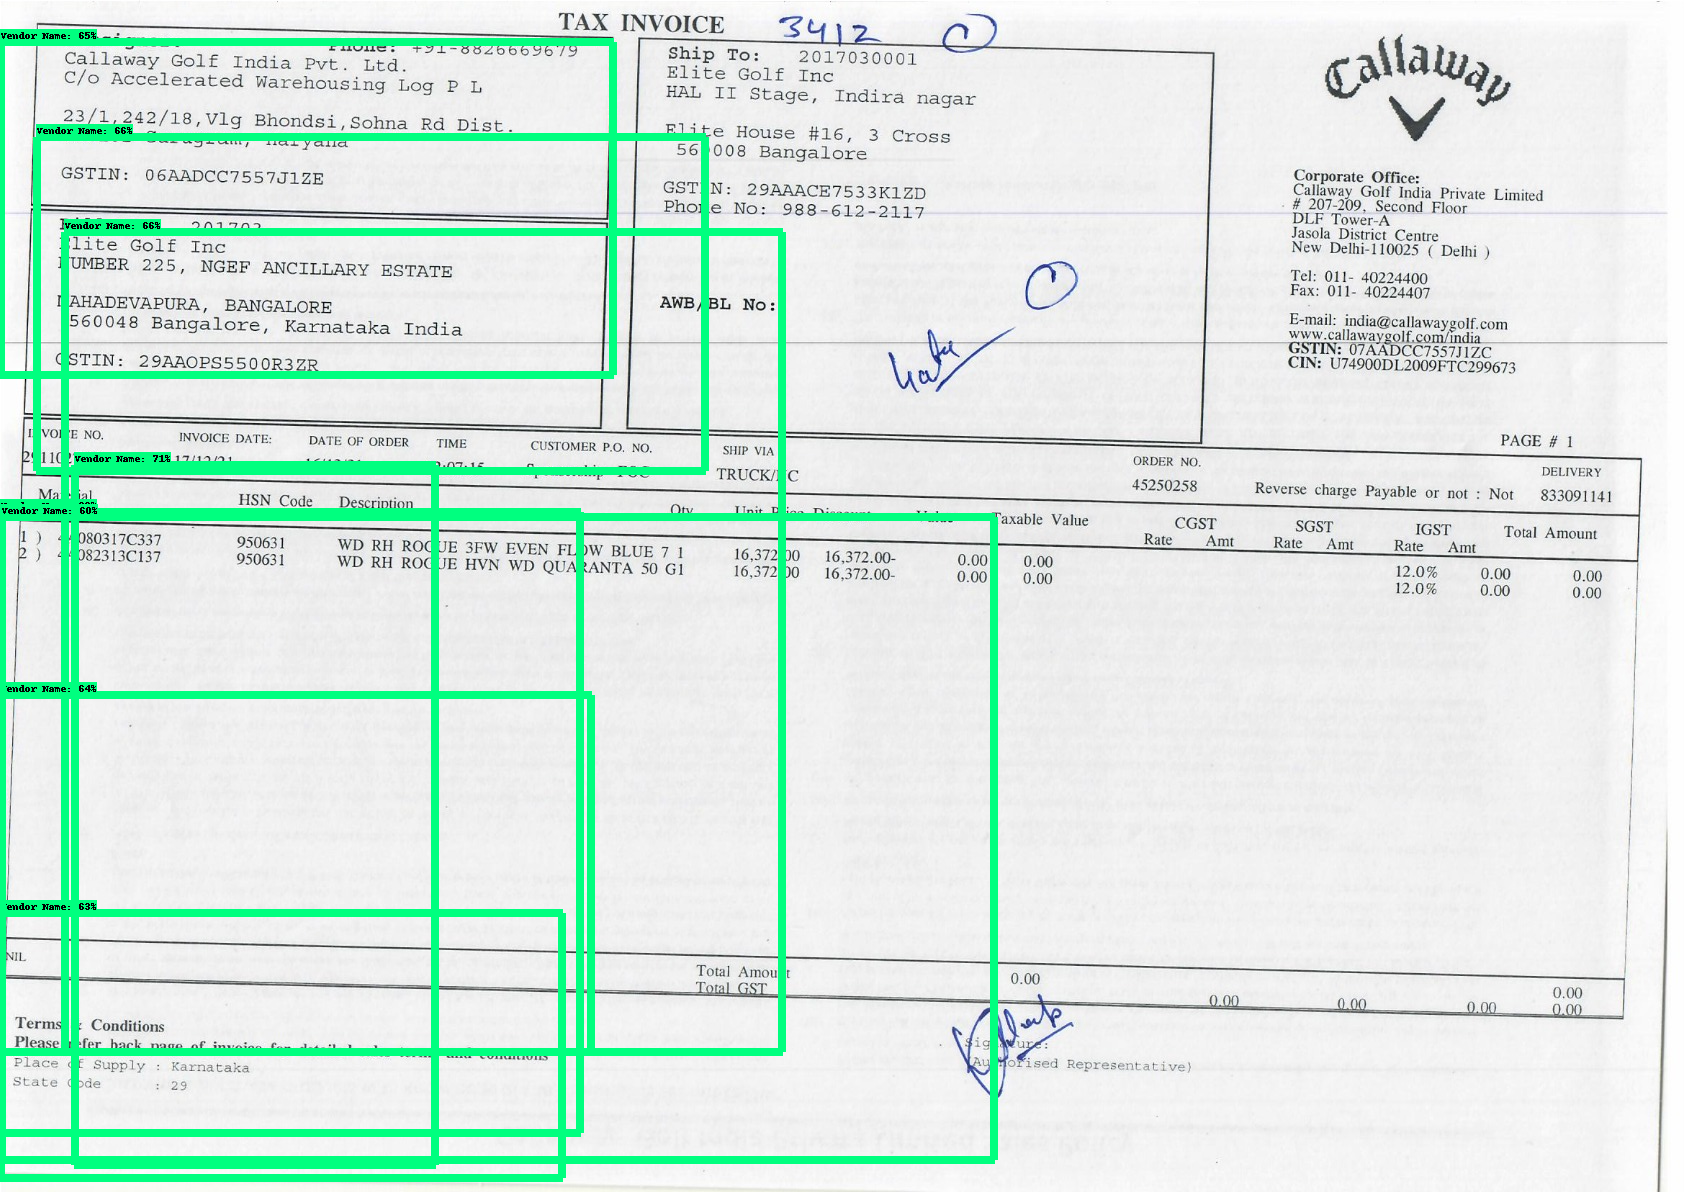

In [22]:
######## Image Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/15/18
# Description: 
# This program uses a TensorFlow-trained neural network to perform object detection.
# It loads the classifier and uses it to perform object detection on an image.
# It draws boxes, scores, and labels around the objects of interest in the image.

## but I changed it to make it more understandable to me.

# Import packages
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'test2.jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 7

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.60)

# All the results have been drawn on image. Now display the image.
cv2_imshow(image)

# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()